## Download necessary libraries

In [ ]:
!pip install praw

ERROR: Operation cancelled by user


In [ ]:
!pip install psaw

## Import Libraries


In [1]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from gensim.utils import simple_preprocess
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
import warnings
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from scipy import stats
# import praw #use for data collection
import datetime
# from psaw import PushshiftAPI #use for data collection
import networkx as nx
import tabulate
import operator
from collections import defaultdict
from nltk.tokenize import word_tokenize
from os.path import exists
import time
import tweepy
from tweepy import OAuthHandler
from tweepy import API
from tweepy import Cursor
import time
from tweepy import Stream
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from textblob import TextBlob    
import requests

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Connect to google drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Setting Location for Ankit

In [3]:
% cd "/content/drive/My Drive/Data Science/Project/Datafiles"
% ls .``

/content/drive/My Drive/Data Analysis/Project/Datafiles
'=4.0.0'                      reddit_data_modelled_first
 centers                      reddit_data_modelled_second
 centers.csv                  reddit_data_month.json
 csv_files/                   reddit_data_text
 figure.png                   reddit_data_text_day
 figures/                     reddit_data_text_month
 json_files/                  reddit_data_time
 json_files_new/              tweet_data_combined
 models/                      tweet_data_combined_backup
 next_tokens                  tweet_data_daily
 next_tokens_backup           tweet_data_day.json
 reddit_data_combined         tweet_data_day_loc.json
 reddit_data_day.json         tweet_data_day_state.json
 reddit_data_labels           tweet_data_labelled
 reddit_data_modelled_1       tweet_data_labels
 reddit_data_modelled_2       tweet_data_language_temp
 reddit_data_modelled_3       tweet_data_modelled
 reddit_data_modelled_4       tweet_data_month.json
 reddit_d

## Connect to reddit API using your key, username and password


In [ ]:
# Add your credentials here
reddit = praw.Reddit(
    client_id="X7RUeJfF7cJeMtbQ1LIt9w",
    client_secret="cnefAHZnBVXmb886eie2nOY1ycSOVg",
    password="ANkiTSthA   03",
    user_agent="Data_Science_Ankit",
    username="ankitstha3",
    check_for_async=False
)

In [ ]:
reddit.read_only = True
api = PushshiftAPI(reddit)

In [ ]:
def get_reddit_posts(start_date, end_date):
  gen = api.search_submissions(q='COVID', after=int(start_date.timestamp()), before=int(end_date.timestamp()), filter=['created_utc', 'title', 'selftext'], limit=10000)
  posts = list(gen)
  return posts

In [ ]:
start_date = datetime.datetime(2020, 2, 11)
end_date = datetime.datetime(2021, 12, 31)
delta = datetime.timedelta(days=1)
if exists('reddit_data_combined'):
  reddit_data_combined=pd.read_csv('reddit_data_combined', header=None)
  reddit_data_combined.columns=['date', 'text']
  reddit_data_combined=reddit_data_combined.dropna()
  reddit_data_combined['date']=pd.to_datetime(reddit_data_combined['date'])
  start_date=reddit_data_combined['date'].max()+delta
while start_date <= end_date:
  temp_end=start_date+delta
  posts=get_reddit_posts(start_date, temp_end)
  date=[datetime.datetime.fromtimestamp(post.created_utc) for post in posts]
  text=[post.title+' '+post.selftext for post in posts]
  reddit_dict={'date':start_date, 'text':text}
  time.sleep(3)
  start_date += delta
  reddit_data_combined = pd.DataFrame.from_dict(reddit_dict)
  reddit_data_combined.to_csv('reddit_data_combined', mode='a', index=False, header=False)

## Connect to twitter API using your key, username and password


In [ ]:
# Put your consumer key and access token key here
C_KEY = 'Po5qq9wQlQ4ABmKsAojUYWyDF'
C_SECRET = 'RTtTq92VQiminG83F32dPJFLsUP2Y6L1QAqYrVZsHtF8NBGhEs'
A_TOKEN_KEY = '2827422426-m0pzklPUXdIx0cypMQa48cD3LKRarc5dp5Wxqzm'
A_TOKEN_SECRET = 'ScMC6G9DRujKagDAqd54uPaaQEgxaa3EN65pH1ov9Dx6T'
B_token= 'AAAAAAAAAAAAAAAAAAAAAGCBawEAAAAAF6DS6dglUv9PgmwMorFWHK9MwD0%3D7wKuOpmrKw8JGEogikHPA8m4Vk9GzRQWsLIQCba58yD4xeJdhe'

In [ ]:
def get_tweets(start_date, end_date, next_token):
  headers = {"Authorization": "Bearer {}".format(B_token)}
  start=start_date.strftime("%Y-%m-%d")
  end=end_date.strftime("%Y-%m-%d")
  expansions='geo.place_id'
  tweet_fields='created_at'
  place_fields='contained_within,country,country_code,full_name,name,geo,place_type'
  # sort_order='relevancy'
  keyword = 'COVID'
  query='{}%20place_country%3AUS'.format(keyword)
  limit='500'
  add_token=''
  if next_token!='':
    add_token=f'&next_token={next_token}'
  url = f'https://api.twitter.com/2/tweets/search/all?query={query}&max_results={limit}&start_time={start}T00%3A00%3A00Z&end_time={end}T00%3A00%3A00Z&expansions={expansions}&tweet.fields={tweet_fields}&place.fields={place_fields}{add_token}'

  response = requests.request("GET", url, headers = headers)
  return response.json()

In [ ]:
def make_dataframe(tweets):
  tweets_texts=tweets['data']
  tweets_location=tweets['includes']['places']

  id=[]
  date=[]
  coordinates=[]
  loc_name=[]
  loc_country=[]
  text=[]
  loc_type=[]
  place_id_tweet=[]
  place_id_loc=[]

  for item in tweets_texts:
    id.append(item['id'])
    date.append(item['created_at'])
    text.append(item['text'])
    place_id_tweet.append(item['geo']['place_id'] if 'geo' in item else -1)

  for item in tweets_location:
    coordinates.append(item['geo']['bbox'] if 'geo' in item else -1)
    loc_name.append(item['full_name'])
    loc_country.append(item['country'])
    loc_type.append(item['place_type'])
    place_id_loc.append(item['id'])

  tweet_dict={'tweet_id':id, 'date':date, 'text':text, 'place_id':place_id_tweet}
  loc_dict={'place_id':place_id_loc, 'coordinates':coordinates, 'loc_name':loc_name, 'loc_country':loc_country, 'loc_type':loc_type}
  tweet_df=pd.DataFrame.from_dict(tweet_dict)
  loc_df=pd.DataFrame.from_dict(loc_dict)
  tweet_data=tweet_df.merge(loc_df, on='place_id')
  return tweet_data

In [ ]:
start_date = datetime.datetime(2020, 2, 11)
end_date = datetime.datetime(2021, 12, 31)
delta = datetime.timedelta(days=1)
next_token=''
count=0
if exists('tweet_data_combined'):
  tweet_data_combined=pd.read_csv('tweet_data_combined', lineterminator='\n', header=None)
  tweet_data_combined.columns=['tweet_id', 'date', 'text', 'place_id', 'coordinates', 'loc_name', 'loc_country', 'loc_type']
  tweet_data_combined=tweet_data_combined.dropna()
  tweet_data_combined['date']=tweet_data_combined['date'].str[:10]+' '+tweet_data_combined['date'].str[11:19]
  tweet_data_combined['date']=pd.to_datetime(tweet_data_combined['date'])
  temp_date=tweet_data_combined['date'].max().date()
  start_date = datetime.datetime(temp_date.year, temp_date.month, temp_date.day)
  start_date+=delta

while start_date <= end_date:
  temp_end=start_date+delta
  tweets=get_tweets(start_date, temp_end, next_token)
  if tweets['meta']['result_count']!=0:
    tweet_data=make_dataframe(tweets)
    tweet_data.to_csv('tweet_data_daily', mode='w', index=False, header=True)
  time.sleep(3)
  while 'next_token' in tweets['meta'] and count<20:
    next_token=tweets['meta']['next_token']
    tweets=get_tweets(start_date, temp_end, next_token)
    if tweets['meta']['result_count']!=0:
      tweet_data=make_dataframe(tweets)
      tweet_data.to_csv('tweet_data_daily', mode='a', index=False, header=False)
    count=count+1
    time.sleep(3)

  if exists('tweet_data_daily'):
    if 'next_token' in tweets['meta']:
      next_token=tweets['meta']['next_token']
    else:
      next_token=''
    if 'newest_id' in tweets['meta']:
      newest_id=tweets['meta']['newest_id']
    else:
      newest_id=''
    temp_token={'date':start_date, 'next_token':[next_token], 'newest_id':newest_id}
    next_tokens=pd.DataFrame.from_dict(temp_token)
    next_tokens.to_csv('next_tokens', mode='a', index=False, header=False)

    tweet_data_combined=pd.read_csv('tweet_data_daily')
    tweet_data_combined.to_csv('tweet_data_combined', mode='a', index=False, header=False)
  start_date += delta
  count=0

In [ ]:
tweet_data_combined=pd.read_csv('tweet_data_combined', lineterminator='\n', header=None)
tweet_data_combined.columns=['tweet_id', 'date', 'text', 'place_id', 'coordinates', 'loc_name', 'loc_country', 'loc_type']
tweet_data_combined=tweet_data_combined.dropna()
tweet_data_combined['date']=tweet_data_combined['date'].str[:10]+' '+tweet_data_combined['date'].str[11:19]
tweet_data_combined['date']=pd.to_datetime(tweet_data_combined['date'])

In [ ]:
reddit_data_combined=pd.read_csv('reddit_data_combined', header=None)
reddit_data_combined.columns=['date', 'text']
reddit_data_combined=reddit_data_combined.dropna()
reddit_data_combined['date']=reddit_data_combined['date'].str[:10]+' '+reddit_data_combined['date'].str[11:19]
reddit_data_combined['date']=pd.to_datetime(reddit_data_combined['date'])

In [ ]:
reddit_data_combined

,date,text,date_only
0,2020-02-11,Are you guys worried about the Coronavirus (CO...,2020-02-11
1,2020-02-11,[World] - WHO names deadly virus from China as...,2020-02-11
2,2020-02-11,Is the COVID-19 death rate calculated correctl...,2020-02-11
3,2020-02-11,[World] - WHO names deadly virus from China as...,2020-02-11
4,2020-02-11,Is the COVID-19 death rate calculated correctl...,2020-02-11
...,...,...,...
5116642,2021-12-31,I Think my future is screwed **INTRO**:\n\nI a...,2021-12-31
5116643,2021-12-31,"The reason Biden saying ""no federal solution t...",2021-12-31
5116644,2021-12-31,Even a broken clock is right twice a day... in...,2021-12-31
5116645,2021-12-31,Question for those who got a PCR test recently...,2021-12-31


In [ ]:
reddit_data_combined['date_only']=reddit_data_combined['date'].dt.date
data_count=reddit_data_combined.groupby('date_only').agg({'text':'count'}).reset_index()

In [ ]:
plt.figure(figsize=(10,10))
# sns.barplot(x='date_only', y='text', data=data_count)
sns.lineplot(x='date_only', y='text', data=data_count)

In [ ]:
tweet_data_combined

,tweet_id,date,text,place_id,coordinates,loc_name,loc_country,loc_type,date_only
0,1227378701140140032,2020-02-11 23:47:40,NBC News: Coronavirus gets official name from ...,19e2bff2e89dc38e,"[-86.505805, 35.751433, -86.313415, 35.943407]","Murfreesboro, TN",United States,city,2020-02-11
1,1227377150044647424,2020-02-11 23:41:30,COVID-19で、🇩🇪経済のみならず、ユーロ圏全体が不景気になる見込み。先進国では社会的セ...,cd450c94084cbf9b,"[-73.508143, 41.187054, -69.858861, 42.8868241]","Massachusetts, USA",United States,admin,2020-02-11
2,1227372076505264128,2020-02-11 23:21:21,UPDATE: 3-year-old Annabel Wucinski was taken ...,a592bd6ceb1319f7,"[-117.282538, 32.53962, -116.9274403, 33.0804044]","San Diego, CA",United States,city,2020-02-11
3,1227361258631917568,2020-02-11 22:38:21,@drsherbdr3 Just a little clarification. The v...,a592bd6ceb1319f7,"[-117.282538, 32.53962, -116.9274403, 33.0804044]","San Diego, CA",United States,city,2020-02-11
4,1227369577358729217,2020-02-11 23:11:25,"""WHO officially names the illness caused by ne...",42e46bc3663a4b5f,"[-97.538285, 32.569477, -97.033542, 32.990456]","Fort Worth, TX",United States,city,2020-02-11
...,...,...,...,...,...,...,...,...,...
2367320,1476704795608059922,2021-12-31 00:00:33,@Fan4Utah @Money23Green The meds created by Pf...,59bb4e6ce17a8b66,"[-122.2884385, 37.533497, -122.245136, 37.575839]","Foster City, CA",United States,city,2021-12-31
2367321,1476704772874915840,2021-12-31 00:00:28,@nickdaschel I wonder what attendance will be ...,3b213491c5ae3f7e,"[-119.3269396, 45.824334, -119.258928, 45.864803]","Hermiston, OR",United States,city,2021-12-31
2367322,1476704766612942851,2021-12-31 00:00:26,Welcome to another episode of ‘Covid test? Or ...,07d9f3254b084001,"[-73.92985972694039, 40.85105983292507, -73.92...",Yeshiva University - Wilf Campus,United States,poi,2021-12-31
2367323,1476704724250468356,2021-12-31 00:00:16,What to do when hubby and I are home with COVI...,94779fa8bb1f79a8,"[-77.694219, 43.087472, -77.516194, 43.167065]","Brighton, NY",United States,city,2021-12-31


In [ ]:
tweet_data_combined['date_only']=tweet_data_combined['date'].dt.date
data_count=tweet_data_combined.groupby('date_only').agg({'text':'count'}).reset_index()

In [ ]:
plt.figure(figsize=(10,10))
# sns.barplot(x='date_only', y='text', data=data_count)
sns.lineplot(x='date_only', y='text', data=data_count)

#Start here for labelling data

In [ ]:
def score_to_sentiment(x):
  if x>=0.2:
    return 'pos'
  elif x<=-0.2:
    return 'neg'
  else:
    return 'neu'

In [ ]:
tweet_data_combined=pd.read_csv('tweet_data_combined', lineterminator='\n', header=None)
tweet_data_combined.columns=['tweet_id', 'date', 'text', 'place_id', 'coordinates', 'loc_name', 'loc_country', 'loc_type']
tweet_data_combined=tweet_data_combined.dropna()
tweet_data_combined['date']=tweet_data_combined['date'].str[:10]+' '+tweet_data_lang['date'].str[11:19]
tweet_data_combined['date']=pd.to_datetime(tweet_data_combined['date'])

tweet_data_labeled=tweet_data_combined.sample(3000)
tweet_data_labeled.to_csv('tweet_data_labeled', mode='a', index=False, header=False)

reddit_data_combined=pd.read_csv('reddit_data_combined', lineterminator='\n', header=None)
reddit_data_combined.columns=['date', 'text']
reddit_data_combined=reddit_data_combined.dropna()
reddit_data_combined['date']=reddit_data_combined['date'].str[:10]+' '+tweet_data_lang['date'].str[11:19]
reddit_data_combined['date']=pd.to_datetime(reddit_data_combined['date'])

reddit_data_labeled=reddit_data_combined.sample(3000)
reddit_data_labeled.to_csv('reddit_data_labeled', mode='a', index=False, header=False)

In [ ]:
tweet_data_lang=pd.read_csv('tweet_data_combined', lineterminator='\n', header=None)
tweet_data_lang.columns=['tweet_id', 'date', 'text', 'place_id', 'coordinates', 'loc_name', 'loc_country', 'loc_type']
tweet_data_lang=tweet_data_lang.dropna()
tweet_data_lang['date']=tweet_data_lang['date'].str[:10]+' '+tweet_data_lang['date'].str[11:19]
tweet_data_lang['date']=pd.to_datetime(tweet_data_lang['date'])

tweet_data_labels=tweet_data_lang.sample(47000)
tweet_data_labels['scores'] = tweet_data_labels['text'].apply(lambda text: sid.polarity_scores(text))
tweet_data_labels['compound']  = tweet_data_labels['scores'].apply(lambda score_dict: score_dict['compound'])
tweet_data_labels['comp_score'] = tweet_data_labels['compound'].apply(lambda c: score_to_sentiment(c))
tweet_data_labels.drop(['scores', 'compound'], axis=1)

tweet_data_labeled=pd.read_csv('tweet_data_labeled', lineterminator='\n')

tweet_data_labels=pd.concat([tweet_data_labels, tweet_data_labeled], ignore_index=True)

In [ ]:
tweet_data_labels.to_csv('tweet_data_labels', mode='w', index=False, header=True)

In [ ]:
pd.crosstab(tweet_data_labels['comp_score'],tweet_data_labels['comp_score'], normalize='all')*100

comp_score,neg,neu,pos
comp_score,,,
neg,31.962,0.000,0.000
neu,0.000,32.382,0.000
pos,0.000,0.000,35.656


In [ ]:
reddit_data_lang=pd.read_csv('reddit_data_combined', header=None)
reddit_data_lang.columns=['date', 'text']
reddit_data_lang=reddit_data_lang.dropna()
reddit_data_lang['date']=reddit_data_lang['date'].str[:10]+' '+reddit_data_lang['date'].str[11:19]
reddit_data_lang['date']=pd.to_datetime(reddit_data_lang['date'])

reddit_data_labels=reddit_data_lang.sample(50000)
reddit_data_labels['scores'] = reddit_data_labels['text'].apply(lambda text: sid.polarity_scores(text))
reddit_data_labels['compound']  = reddit_data_labels['scores'].apply(lambda score_dict: score_dict['compound'])
reddit_data_labels['comp_score'] = reddit_data_labels['compound'].apply(lambda c: score_to_sentiment(c))
reddit_data_labels.drop(['scores', 'compound'], axis=1)

reddit_data_labeled=pd.read_csv('reddit_data_labeled', lineterminator='\n')

reddit_data_labeled=pd.concat([reddit_data_labels, reddit_data_labeled], ignore_index=True)

reddit_data_labels

,date,text,scores,compound,comp_score
200773,2020-03-27,How are Veterinary Clinics handling euthanasia...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neu
3281928,2021-04-07,Officials: Covid surge at Pitt 'endangering ou...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neu
3004755,2021-02-22,[Top Stories] - Covid lockdown: 'We are burnin...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neu
365915,2020-04-14,"So, How Does One Join This Covid-19 Cult?","{'neg': 0.0, 'neu': 0.761, 'pos': 0.239, 'comp...",0.2960,pos
2621917,2021-01-09,Anti-propaganda portal: COVID-19 Facebook misi...,"{'neg': 0.247, 'neu': 0.753, 'pos': 0.0, 'comp...",-0.3182,neg
...,...,...,...,...,...
2494150,2020-12-27,Post-COVID Rest? [removed],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neu
4343594,2021-08-30,"Recovering from Delta, need help finding solid...","{'neg': 0.099, 'neu': 0.79, 'pos': 0.111, 'com...",0.6177,pos
2274125,2020-12-04,my grandpa is dying and reddit called me an as...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neu
884123,2020-06-13,It’s his “lifestyle” [deleted],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neu


In [ ]:
reddit_data_labels.to_csv('reddit_data_labels', mode='w', index=False, header=True)

In [ ]:
pd.crosstab(reddit_data_labels['comp_score'],reddit_data_labels['comp_score'], normalize='all')*100

comp_score,neg,neu,pos
comp_score,,,
neg,25.572,0.000,0.000
neu,0.000,42.234,0.000
pos,0.000,0.000,32.194


# Imports

# Data importing

In [ ]:
tweet_data_labels=pd.read_csv('tweet_data_labels', lineterminator='\n')
tweet_data_labels=tweet_data_labels.dropna()
tweet_data_labels['date']=tweet_data_labels['date'].str[:10]+' '+tweet_data_labels['date'].str[11:19]
tweet_data_labels['date']=pd.to_datetime(tweet_data_labels['date'])

In [ ]:
reddit_data_labels=pd.read_csv('reddit_data_labels', lineterminator='\n')
reddit_data_labels=reddit_data_labels.dropna()
reddit_data_labels['date']=reddit_data_labels['date'].str[:10]+' '+reddit_data_labels['date'].str[11:19]
reddit_data_labels['date']=pd.to_datetime(reddit_data_labels['date'])

# Data exploration

In [ ]:
#Let's get the dataset lenght
display(len(tweet_data_labels))
len(reddit_data_labels)

50000

50000

In [ ]:
display(tweet_data_labels['comp_score'].unique())
reddit_data_labels['comp_score'].unique()

array(['neg', 'pos', 'neu'], dtype=object)

array(['neu', 'pos', 'neg'], dtype=object)

# Data cleaning

Even when the dataset is a little bit biased, we'll keep it this way because the differences are not significant.

In [ ]:
#Let's keep only the columns that we're going to use
train_tweet = tweet_data_labels[['text','comp_score']]
train_reddit = reddit_data_labels[['text','comp_score']]

train=pd.concat([train_tweet, train_reddit], ignore_index=True)
train.head()

,text,comp_score
0,The grief watching some people and businesses ...,neg
1,"I got the covid vaccine and I feel like shit, ...",pos
2,@KCGrock @Momifornia1 @LondonBreed Please sign...,pos
3,"Re-upping what I said in 2020…\n\nI swear, if ...",neu
4,https://t.co/J03PLS8U87,neu


In [ ]:
#Is there any null value?
train["text"].isnull().sum()

0

In [ ]:
#Let's fill the only null value.
train["selected_text"].fillna("No content", inplace = True)
train["text"]=train["selected_text"]

### The next steps about data cleaning will be:

* Remove URLs from the tweets
* Tokenize text
* Remove emails
* Remove new lines characters
* Remove distracting single quotes
* Remove all punctuation signs
* Lowercase all text
* Detokenize text
* Convert list of texts to Numpy array

# Data cleaning sequencing and splitting

We'll implement the Keras tokenizer as well as its pad_sequences method to transform our text data into 3D float data, otherwise our neural networks won't be able to be trained on it.

In [ ]:
def depure_data(data):
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)
    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)
    # Remove new line characters
    data = re.sub('\s+', ' ', data)
    # Remove distracting single quotes
    data = re.sub("\'", "", data)
    # Remove punctuations    
    data = re.sub(r'[^\w\s]', '', data) 
    return data

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def make_sequence(data):
  max_words = 5000
  max_len = 200
  tokenizer = Tokenizer(num_words=max_words)
  tokenizer.fit_on_texts(data)
  sequences = tokenizer.texts_to_sequences(data)
  tweets = pad_sequences(sequences, maxlen=max_len)
  return tweets

def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

def cleanup_data(data):
  temp = []
  data_to_list = data['text'].values.tolist()
  for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i].lower()))
  data_words = list(sent_to_words(temp))
  data = []
  for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
  tweets=make_sequence(data)
  return tweets

In [ ]:
tweets=cleanup_data(train)

In [ ]:
tweets

array([[   0,    0,    0, ...,    2,   88,   37],
       [   0,    0,    0, ...,  204,   13,  388],
       [   0,    0,    0, ...,  356,   13, 3022],
       ...,
       [   0,    0,    0, ...,  193,  601,   76],
       [   0,    0,    0, ...,   73, 2808,   76],
       [   0,    0,    0, ...,   57,    6, 3534]], dtype=int32)

# Label encoding

As the dataset is categorical, we need to convert the sentiment labels from Neutral, Negative and Positive to a float type that our model can understand. To achieve this task, we'll implement the to_categorical method from Keras.

In [ ]:
labels = np.array(train['comp_score'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neu':
        y.append(0)
    if labels[i] == 'neg':
        y.append(1)
    if labels[i] == 'pos':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [ ]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=7, shuffle=True)
print (len(X_train),len(X_test),len(y_train),len(y_test))

75000 25000 75000 25000


## Bidirectional LTSM model

In [ ]:
# Creating Attention for LSTM

from keras.layers import Layer
from keras import backend as K, initializers, regularizers, constraints

def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        # todo: check that this is correct
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)


class Attention(Layer):
    def __init__(self,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False,
                 **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Note: The layer has been tested with Keras 1.x
        Example:
        
            # 1
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
            # next add a Dense layer (for classification/regression) or whatever...
            # 2 - Get the attention scores
            hidden = LSTM(64, return_sequences=True)(words)
            sentence, word_scores = Attention(return_attention=True)(hidden)
        """
        self.supports_masking = True
        self.return_attention = return_attention
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(Attention, self).__init__(**kwargs)

    def get_config(self):
        config = super().get_config()
        config.update({
            "W_regularizer": self.W_regularizer,
            "b_regularizer": self.b_regularizer,
            "W_constraint": self.W_constraint,
            "b_constraint": self.b_constraint,
            "bias": self.bias,
            "return_attention": self.return_attention,
        })
        return config

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        eij = dot_product(x, self.W)

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        weighted_input = x * K.expand_dims(a)

        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]

In [ ]:
max_words=5000
max_len=200
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len))
model.add(layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(layers.Dropout(0.25))
model.add(layers.LeakyReLU(alpha=0.05))
model.add(layers.LSTM(32, dropout=0.1, activation='tanh', recurrent_dropout=0.1,return_sequences=True))
model.add(Attention())
model.add(layers.Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 40)           200000    
                                                                 
 lstm (LSTM)                 (None, 200, 32)           9344      
                                                                 
 dropout (Dropout)           (None, 200, 32)           0         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 200, 32)           0         
                                                                 
 lstm_1 (LSTM)               (None, 200, 32)           8320      
                                                                 
 attention (Attention)       (None, 32)                232       
                                                                 
 dense (Dense)               (None, 3)                 9

In [ ]:
history=model.fit(X_train, y_train, epochs=35, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/35
1172/1172 [==============================] - 590s 497ms/step - loss: 0.9228 - accuracy: 0.5567 - val_loss: 0.7819 - val_accuracy: 0.6626
Epoch 2/35
1172/1172 [==============================] - 575s 490ms/step - loss: 0.6718 - accuracy: 0.7359 - val_loss: 0.5841 - val_accuracy: 0.7801
Epoch 3/35
1172/1172 [==============================] - 574s 490ms/step - loss: 0.5536 - accuracy: 0.7973 - val_loss: 0.5301 - val_accuracy: 0.8118
Epoch 4/35
1172/1172 [==============================] - 571s 488ms/step - loss: 0.5073 - accuracy: 0.8161 - val_loss: 0.4941 - val_accuracy: 0.8214
Epoch 5/35
1172/1172 [==============================] - 570s 487ms/step - loss: 0.4787 - accuracy: 0.8287 - val_loss: 0.4762 - val_accuracy: 0.8335
Epoch 6/35
1172/1172 [==============================] - 569s 485ms/step - loss: 0.4576 - accuracy: 0.8380 - val_loss: 0.4660 - val_accuracy: 0.8345
Epoch 7/35
1172/1172 [==============================] - 570s 487ms/step - loss: 0.4427 - accuracy: 0.8432 - val_

In [ ]:
model.save('models/model.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


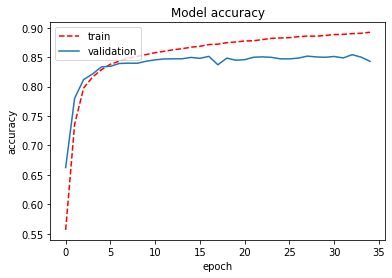

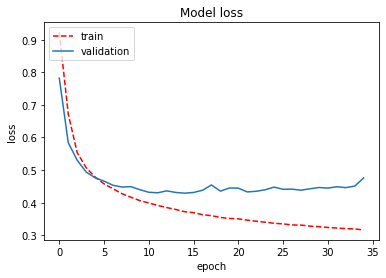

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'], 'r--')
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'], 'r--')
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
history=model.fit(tweets, labels, epochs=10, batch_size=64)

In [ ]:
max_words=5000
max_len=200
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model2.add(layers.Dropout(0.25))
model2.add(layers.LeakyReLU(alpha=0.05))
model2.add(layers.LSTM(32, dropout=0.1, activation='tanh', recurrent_dropout=0.1))
model2.add(layers.Dense(3, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model2.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 200, 40)           200000    
                                                                 
 lstm_22 (LSTM)              (None, 200, 32)           9344      
                                                                 
 dropout_11 (Dropout)        (None, 200, 32)           0         
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 200, 32)           0         
                                                                 
 lstm_23 (LSTM)              (None, 32)                8320      
                                                                 
 dense_11 (Dense)            (None, 3)                 99        
                                                                 
Total params: 217,763
Trainable params: 217,763
Non-t

In [ ]:
history2=model2.fit(X_train, y_train, epochs=35, batch_size=64, validation_data=(X_test, y_test))

In [ ]:
model2.save('models/model2_lstm.h5')

In [ ]:
print(history2.history.keys())
#  "Accuracy"
plt.plot(history2.history['accuracy'], 'r--')
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history2.history['loss'], 'r--')
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Predicitng using model


In [ ]:
# Redefine model for loading weights
max_words=5000
max_len=200
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len))
model.add(layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(layers.Dropout(0.25))
model.add(layers.LeakyReLU(alpha=0.05))
model.add(layers.LSTM(32, dropout=0.1, activation='tanh', recurrent_dropout=0.1,return_sequences=True))
model.add(Attention())
model.add(layers.Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Load the model obtained during training
model.load_weights("models/model.h5")

In [ ]:
def depure_data(data):
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)
    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)
    # Remove new line characters
    data = re.sub('\s+', ' ', data)
    # Remove distracting single quotes
    data = re.sub("\'", "", data)    
    return data

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def make_sequence(data):
  max_words = 5000
  max_len = 200
  tokenizer = Tokenizer(num_words=max_words)
  tokenizer.fit_on_texts(data)
  data = tokenizer.texts_to_sequences(data)
  data = pad_sequences(data, maxlen=max_len)
  return data

def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

def cleanup_data(data):
  temp = []
  data_to_list = data['text'].values.tolist()
  for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
  data_to_list = list(sent_to_words(temp))
  temp = []
  for i in range(len(data_to_list)):
    temp.append(detokenize(data_to_list[i]))
  data_to_list=make_sequence(temp)
  return data_to_list

In [ ]:
tweet_data_lang=pd.read_csv('tweet_data_combined', lineterminator='\n', header=None)
tweet_data_lang.columns=['tweet_id', 'date', 'text', 'place_id', 'coordinates', 'loc_name', 'loc_country', 'loc_type']
tweet_data_lang=tweet_data_lang.dropna()
tweet_data_lang['date']=tweet_data_lang['date'].str[:10]+' '+tweet_data_lang['date'].str[11:19]
tweet_data_lang['date']=pd.to_datetime(tweet_data_lang['date'])

In [ ]:
sentiment = ['neu','neg','pos']
tweet_clean=cleanup_data(tweet_data_lang)
predictions = model.predict(tweet_clean)
text_predictions=[]
for prediction in predictions:
  text_predictions.append(sentiment[np.around([prediction], decimals=0).argmax(axis=1)[0]])
tweet_data_lang['comp_score']=text_predictions

In [ ]:
tweet_data_lang.to_csv('tweet_data_modelled', mode='w', index=False, header=True)

In [ ]:
reddit_data_lang=pd.read_csv('reddit_data_combined', header=None)
reddit_data_lang.columns=['date', 'text']
reddit_data_lang=reddit_data_lang.dropna()
reddit_data_lang['date']=reddit_data_lang['date'].str[:10]+' '+reddit_data_lang['date'].str[11:19]
reddit_data_lang['date']=pd.to_datetime(reddit_data_lang['date'])

In [ ]:
reddit_data_lang=[]

In [ ]:
# Breaking data to manage memory
reddit_data_lang1=reddit_data_lang[:3000000]
reddit_data_lang1.to_csv('reddit_data_modelled_first', mode='w', index=False, header=True)
reddit_data_lang2=reddit_data_lang[3000000:]
reddit_data_lang2.to_csv('reddit_data_modelled_second', mode='w', index=False, header=True)

In [ ]:
# Breaking data to manage memory
reddit_data_lang=pd.read_csv('reddit_data_modelled_first')
reddit_data_lang=reddit_data_lang.dropna()
reddit_data_lang['date']=reddit_data_lang['date'].str[:10]+' '+reddit_data_lang['date'].str[11:19]
reddit_data_lang['date']=pd.to_datetime(reddit_data_lang['date'])
reddit_data_lang1=reddit_data_lang[:1000000]
reddit_data_lang1.to_csv('reddit_data_modelled_1', mode='w', index=False, header=True)
reddit_data_lang1=reddit_data_lang[1000000:2000000]
reddit_data_lang1.to_csv('reddit_data_modelled_=2', mode='w', index=False, header=True)
reddit_data_lang1=reddit_data_lang[2000000:]
reddit_data_lang1.to_csv('reddit_data_modelled_3', mode='w', index=False, header=True)

In [ ]:
# Breaking data to manage memory
reddit_data_lang=pd.read_csv('reddit_data_modelled_second')
reddit_data_lang=reddit_data_lang.dropna()
reddit_data_lang['date']=reddit_data_lang['date'].str[:10]+' '+reddit_data_lang['date'].str[11:19]
reddit_data_lang['date']=pd.to_datetime(reddit_data_lang['date'])
reddit_data_lang1=reddit_data_lang[:1000000]
reddit_data_lang1.to_csv('reddit_data_modelled_4', mode='w', index=False, header=True)
reddit_data_lang1=reddit_data_lang[1000000:2000000]
reddit_data_lang1.to_csv('reddit_data_modelled_5', mode='w', index=False, header=True)
reddit_data_lang1=reddit_data_lang[2000000:]
reddit_data_lang1.to_csv('reddit_data_modelled_6', mode='w', index=False, header=True)

In [ ]:
# Predicting sentiment for the first 1 million data only
reddit_data_lang=pd.read_csv('reddit_data_modelled_1')
reddit_data_lang=reddit_data_lang.dropna()
reddit_data_lang['date']=reddit_data_lang['date'].str[:10]+' '+reddit_data_lang['date'].str[11:19]
reddit_data_lang['date']=pd.to_datetime(reddit_data_lang['date'])

In [ ]:
sentiment = ['neu','neg','pos']
tweet_clean=cleanup_data(reddit_data_lang)
predictions = model.predict(tweet_clean)
text_predictions=[]
for prediction in predictions:
  text_predictions.append(sentiment[np.around([prediction], decimals=0).argmax(axis=1)[0]])
reddit_data_lang['comp_score']=text_predictions

In [ ]:
reddit_data_lang.to_csv('reddit_data_modelled_1', mode='w', index=False, header=True)

In [ ]:
reddit_data_lang.head()

,date,text,comp_score
0,2020-02-11,Are you guys worried about the Coronavirus (CO...,neu
1,2020-02-11,[World] - WHO names deadly virus from China as...,pos
2,2020-02-11,Is the COVID-19 death rate calculated correctl...,neg
3,2020-02-11,[World] - WHO names deadly virus from China as...,neu
4,2020-02-11,Is the COVID-19 death rate calculated correctl...,neu


In [ ]:
reddit_data_lang.count()

date          1000000
text          1000000
comp_score    1000000
dtype: int64

In [ ]:
# Predicting sentiment for the remaining data in loop
for i in range (2, 7):
  reddit_data_lang=pd.read_csv('reddit_data_modelled_'+str(i))
  reddit_data_lang=reddit_data_lang.dropna()
  reddit_data_lang['date']=reddit_data_lang['date'].str[:10]+' '+reddit_data_lang['date'].str[11:19]
  reddit_data_lang['date']=pd.to_datetime(reddit_data_lang['date'])

  sentiment = ['neu','neg','pos']
  tweet_clean=cleanup_data(reddit_data_lang)
  predictions = model.predict(tweet_clean)
  text_predictions=[]
  for prediction in predictions:
    text_predictions.append(sentiment[np.around([prediction], decimals=0).argmax(axis=1)[0]])
  reddit_data_lang['comp_score']=text_predictions

  reddit_data_lang.to_csv('reddit_data_modelled_'+str(i), mode='w', index=False, header=True)

In [ ]:
# combining the files
reddit_data_lang1=pd.read_csv('reddit_data_modelled_1')
for i in range (2, 7):
    reddit_data_lang2=pd.read_csv('reddit_data_modelled_'+str(i))
    reddit_data_lang1=pd.concat([reddit_data_lang1, reddit_data_lang2], ignore_index=True)

reddit_data_lang1.head()

,date,text,comp_score
0,2020-02-11,Are you guys worried about the Coronavirus (CO...,neu
1,2020-02-11,[World] - WHO names deadly virus from China as...,pos
2,2020-02-11,Is the COVID-19 death rate calculated correctl...,neg
3,2020-02-11,[World] - WHO names deadly virus from China as...,neu
4,2020-02-11,Is the COVID-19 death rate calculated correctl...,neu


In [ ]:
reddit_data_lang1.to_csv('reddit_data_modelled_final', mode='w', index=False, header=True)

# Post Processing

In [ ]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "Virgin Islands": "VI",
}

In [ ]:
abbrev_to_us_state = dict(map(reversed, us_state_to_abbrev.items()))

In [ ]:
abbrev_to_us_state['TN']

'Tennessee'

In [ ]:
tweet_data_labels=pd.read_csv('tweet_data_modelled')
tweet_data_labels=tweet_data_labels.dropna()
tweet_data_labels['date']=tweet_data_labels['date'].str[:10]+' '+tweet_data_labels['date'].str[11:19]
tweet_data_labels['date']=pd.to_datetime(tweet_data_labels['date'])

In [ ]:
pd.crosstab(tweet_data_labels['comp_score'],tweet_data_labels['comp_score'], normalize='all')*100

comp_score,neg,neu,pos
comp_score,,,
neg,26.310555,0.000000,0.00000
neu,0.000000,39.931465,0.00000
pos,0.000000,0.000000,33.75798


In [ ]:
  reddit_data_labels=pd.read_csv('reddit_data_modelled_final', lineterminator='\n')
  reddit_data_labels=reddit_data_labels.dropna()
  reddit_data_labels['date']=reddit_data_labels['date'].str[:10]+' '+reddit_data_labels['date'].str[11:19]
  reddit_data_labels['date']=pd.to_datetime(reddit_data_labels['date'])

In [ ]:
pd.crosstab(reddit_data_labels['comp_score'],reddit_data_labels['comp_score'], normalize='all')*100

comp_score,neg,neu,pos
comp_score,,,
neg,28.907643,0.000000,0.00000
neu,0.000000,39.081487,0.00000
pos,0.000000,0.000000,32.01087


In [ ]:
def get_state(location):
  loc=location.split(', ')
  if loc[1]=='USA':
    return us_state_to_abbrev[loc[0]]
  else:
    return loc[1]

In [ ]:
tweet_data_labels = pd.get_dummies(data=tweet_data_labels, columns=['comp_score'], drop_first=False)

tweet_data_labels=tweet_data_labels[(tweet_data_labels.loc_type=='city') | (tweet_data_labels.loc_type=='admin')]

tweet_data_labels=tweet_data_labels[tweet_data_labels.loc_name.str.split(', ', expand=True)[0]!='Tumon']
tweet_data_labels=tweet_data_labels[tweet_data_labels.loc_name.str.split(', ', expand=True)[0]!='Barrigada']
tweet_data_labels=tweet_data_labels[tweet_data_labels.loc_name.str.split(', ', expand=True)[0]!='Maite']
tweet_data_labels=tweet_data_labels[tweet_data_labels.loc_name.str.split(', ', expand=True)[0]!='Barrigada Heights']
tweet_data_labels=tweet_data_labels[tweet_data_labels.loc_name.str.split(', ', expand=True)[0]!='Santa Rita']
tweet_data_labels=tweet_data_labels[tweet_data_labels.loc_name.str.split(', ', expand=True)[0]!='Dededo']
tweet_data_labels=tweet_data_labels[tweet_data_labels.loc_name.str.split(', ', expand=True)[0]!='Toto']

tweet_data_labels=tweet_data_labels[tweet_data_labels.loc_name.str.contains(',')]

tweet_data_labels['state'] = tweet_data_labels['loc_name'].apply(lambda c: get_state(c))

tweet_data_labels['date_only']=tweet_data_labels['date'].dt.date

tweet_data_labels['month'] = tweet_data_labels['date'].dt.month
tweet_data_labels['year'] = tweet_data_labels['date'].dt.year

tweet_data_labels['comp_score_pos']=tweet_data_labels['comp_score_pos'].astype(int)
tweet_data_labels['comp_score_neg']=tweet_data_labels['comp_score_neg'].astype(int)
tweet_data_labels['comp_score_neu']=tweet_data_labels['comp_score_neu'].astype(int)

tweet_data_labels['sent_score']=tweet_data_labels['comp_score_pos']-tweet_data_labels['comp_score_neg']

In [ ]:
# Function to get freq words
stop = stopwords.words('english')
stop.extend(['covid', 'covid-19', 'covid19', '&amp;', '#covid_19', 'coronavirus', 'covid.', ' ', '', '-', '|', '&#x200b;', '*', '>', '<'])

def freq_words(tweet):
  counts=defaultdict(int)
  tweet=depure_data(tweet)
  words=tweet.split(' ')
  for word in words:
    word=word.lower()
    if word not in (stop):
      counts[word]+=1

  sorted_words=sorted(counts.items(), key=operator.itemgetter(1), reverse=True)
  return sorted_words[:20]

In [ ]:
reddit_data_labels=[]
for i in range(6):
  reddit_data_labels.append(pd.read_csv('reddit_data_modelled_'+str(i+1), lineterminator='\n'))
  reddit_data_labels[i]=reddit_data_labels[i].dropna()
  reddit_data_labels[i]['date']=reddit_data_labels[i]['date'].str[:10]+' '+reddit_data_labels[i]['date'].str[11:19]
  reddit_data_labels[i]['date']=pd.to_datetime(reddit_data_labels[i]['date'])

  reddit_data_labels[i] = pd.get_dummies(data=reddit_data_labels[i], columns=['comp_score'], drop_first=False)

  reddit_data_labels[i]['date_only']=reddit_data_labels[i]['date'].dt.date

  reddit_data_labels[i]['month'] = reddit_data_labels[i]['date'].dt.month
  reddit_data_labels[i]['year'] = reddit_data_labels[i]['date'].dt.year

  reddit_data_labels[i]['comp_score_pos']=reddit_data_labels[i]['comp_score_pos'].astype(int)
  reddit_data_labels[i]['comp_score_neg']=reddit_data_labels[i]['comp_score_neg'].astype(int)
  reddit_data_labels[i]['comp_score_neu']=reddit_data_labels[i]['comp_score_neu'].astype(int)

  reddit_data_labels[i]['sent_score']=reddit_data_labels[i]['comp_score_pos']-reddit_data_labels[i]['comp_score_neg']

  reddit_data_labels[i]=(reddit_data_labels[i].groupby(['date_only', 'month', 'year'])['text'].apply(lambda x: ' '.join(x)).reset_index())

In [ ]:
reddit_data=reddit_data_labels[0]
for i in range (1, 6):
    reddit_data=pd.concat([reddit_data, reddit_data_labels[i]], ignore_index=True)

reddit_data_labels=0
reddit_data

,date_only,month,year,text
0,2020-02-11,2,2020,Are you guys worried about the Coronavirus (CO...
1,2020-02-12,2,2020,'Way too early' to predict end of COVID-19 cor...
2,2020-02-13,2,2020,Time is right for ATHX [removed] @TheEconomist...
3,2020-02-14,2,2020,Come join our user-moderated Discord Server to...
4,2020-02-15,2,2020,"Keto Prepper Supplies? So, hub and I are mild ..."
...,...,...,...,...
673,2021-12-27,12,2021,Nick Hudson of PANDA on recent events indicati...
674,2021-12-28,12,2021,Seeking marathon medal! [removed] [deleted by ...
675,2021-12-29,12,2021,"Saying ""I'd rather have multiplayer cost $60"" ..."
676,2021-12-30,12,2021,CDC Director Admits Latest COVID Restrictions ...


In [ ]:
del reddit_data_labels

In [ ]:
reddit_data=reddit_data.groupby(['date_only', 'month', 'year'])['text'].apply(lambda x: ' '.join(x)).reset_index()

In [ ]:
reddit_data['freq_words'] = reddit_data['text'].apply(lambda c: freq_words(c))

In [ ]:
reddit_data_text_day=reddit_data[['date_only', 'month', 'year', 'freq_words']]

reddit_data_text_day.to_csv('reddit_data_text_day', mode='w', index=False, header=True)
reddit_data_text_day

,date_only,month,year,freq_words
0,2020-02-11,2,2020,"[(new, 57), (name, 48), (officially, 33), (vir..."
1,2020-02-12,2,2020,"[(new, 82), (cases, 59), ([removed], 57), (vir..."
2,2020-02-13,2,2020,"[(virus, 98), (china, 89), (cases, 77), (new, ..."
3,2020-02-14,2,2020,"[(outbreak, 148), (|[who, 138), (information, ..."
4,2020-02-15,2,2020,"[(virus, 72), (people, 62), (health, 60), (cas..."
...,...,...,...,...
668,2021-12-27,12,2021,"[(get, 2176), (like, 1998), (im, 1981), (would..."
669,2021-12-28,12,2021,"[(get, 2454), (like, 2297), (would, 1926), (im..."
670,2021-12-29,12,2021,"[(get, 2315), (like, 2240), (im, 2024), (new, ..."
671,2021-12-30,12,2021,"[(get, 2441), (like, 2328), (im, 2048), (new, ..."


In [ ]:
reddit_data_labels=[]
for i in range(6):
  reddit_data_labels.append(pd.read_csv('reddit_data_modelled_'+str(i+1), lineterminator='\n'))
  reddit_data_labels[i]=reddit_data_labels[i].dropna()
  reddit_data_labels[i]['date']=reddit_data_labels[i]['date'].str[:10]+' '+reddit_data_labels[i]['date'].str[11:19]
  reddit_data_labels[i]['date']=pd.to_datetime(reddit_data_labels[i]['date'])

  reddit_data_labels[i] = pd.get_dummies(data=reddit_data_labels[i], columns=['comp_score'], drop_first=False)

  reddit_data_labels[i]['date_only']=reddit_data_labels[i]['date'].dt.date

  reddit_data_labels[i]['month'] = reddit_data_labels[i]['date'].dt.month
  reddit_data_labels[i]['year'] = reddit_data_labels[i]['date'].dt.year

  reddit_data_labels[i]['comp_score_pos']=reddit_data_labels[i]['comp_score_pos'].astype(int)
  reddit_data_labels[i]['comp_score_neg']=reddit_data_labels[i]['comp_score_neg'].astype(int)
  reddit_data_labels[i]['comp_score_neu']=reddit_data_labels[i]['comp_score_neu'].astype(int)

  reddit_data_labels[i]['sent_score']=reddit_data_labels[i]['comp_score_pos']-reddit_data_labels[i]['comp_score_neg']

  reddit_data_labels[i]=(reddit_data_labels[i].groupby(['month', 'year'])['text'].apply(lambda x: ' '.join(x)).reset_index())
  reddit_data_labels[i]['freq_words'] = reddit_data_labels[i]['text'].apply(lambda c: freq_words(c))

  reddit_data_labels[i]=reddit_data_labels[i][['month', 'year', 'freq_words']]

In [ ]:
reddit_data=reddit_data_labels[0]
for i in range (1, 6):
    reddit_data=pd.concat([reddit_data, reddit_data_labels[i]], ignore_index=True)

reddit_data_labels=0

In [ ]:
reddit_data.sort_values(by=['year', 'month'])

In [ ]:
def combine_freq_agg(freq_words):
  counts=defaultdict(int)
  for item in freq_words:
    for words in item:
      counts[words[0]]+=words[1]

  sorted_words=sorted(counts.items(), key=operator.itemgetter(1), reverse=True)
  return sorted_words[:40]

In [ ]:
#combining boundary aggregations from different files
reddit_data.at[4,'freq_words']=combine_freq_agg(list(reddit_data[(reddit_data.month==6) & (reddit_data.year==2020)]['freq_words']))
reddit_data.at[10,'freq_words']=combine_freq_agg(list(reddit_data[(reddit_data.month==11) & (reddit_data.year==2020)]['freq_words']))
reddit_data.at[12,'freq_words']=combine_freq_agg(list(reddit_data[(reddit_data.month==2) & (reddit_data.year==2021)]['freq_words']))
reddit_data.at[20,'freq_words']=combine_freq_agg(list(reddit_data[(reddit_data.month==7) & (reddit_data.year==2021)]['freq_words']))
reddit_data.at[26,'freq_words']=combine_freq_agg(list(reddit_data[(reddit_data.month==12) & (reddit_data.year==2021)]['freq_words']))

In [ ]:
reddit_data=reddit_data.drop([5, 13, 15, 21, 27])

In [ ]:
reddit_data=reddit_data.reset_index().drop(['index'], axis=1)

In [ ]:
reddit_data_text_month=reddit_data[['month', 'year', 'freq_words']]

In [ ]:
reddit_data_text_month.to_csv('reddit_data_text_month', mode='w', index=False, header=True)

In [ ]:
reddit_data_labels=pd.read_csv('reddit_data_modelled_final', lineterminator='\n')
reddit_data_labels=reddit_data_labels.dropna()
reddit_data_labels['date']=reddit_data_labels['date'].str[:10]+' '+reddit_data_labels['date'].str[11:19]
reddit_data_labels['date']=pd.to_datetime(reddit_data_labels['date'])

reddit_data_labels = pd.get_dummies(data=reddit_data_labels, columns=['comp_score'], drop_first=False)

reddit_data_labels['date_only']=reddit_data_labels['date'].dt.date

reddit_data_labels['month'] = reddit_data_labels['date'].dt.month
reddit_data_labels['year'] = reddit_data_labels['date'].dt.year

reddit_data_labels['comp_score_pos']=reddit_data_labels['comp_score_pos'].astype(int)
reddit_data_labels['comp_score_neg']=reddit_data_labels['comp_score_neg'].astype(int)
reddit_data_labels['comp_score_neu']=reddit_data_labels['comp_score_neu'].astype(int)

reddit_data_labels['sent_score']=reddit_data_labels['comp_score_pos']-reddit_data_labels['comp_score_neg']

# Exporting data for web

# Daily and monthly sentiment for reddit and twitter comparison

In [ ]:
stop = stopwords.words('english')
stop.extend(['covid', 'covid-19', 'covid19', '&amp;', '#covid_19', 'coronavirus', 'covid.', ' ', ''])

def freq_words(tweet):
  counts=defaultdict(int)
  tweet=depure_data(tweet)
  words=tweet.split(' ')
  for word in words:
    word=word.lower()
    if word not in (stop):
      counts[word]+=1

  sorted_words=sorted(counts.items(), key=operator.itemgetter(1), reverse=True)
  return sorted_words[:20]

In [ ]:
tweet_data_time=tweet_data_labels.groupby('date_only').agg({'month':'max', 'year':'max', 'date':'count', 'sent_score':'sum',  'comp_score_neg':'sum', 'comp_score_neu':'sum', 'comp_score_pos':'sum'})
tweet_data_time_text=tweet_data_labels.groupby(['date_only', 'month', 'year'])['text'].apply(lambda x: ' '.join(x)).reset_index()
tweet_data_time=tweet_data_time.merge(tweet_data_time_text, on=['date_only', 'month', 'year'])

tweet_data_time['sent_score_s']=tweet_data_time['sent_score']/tweet_data_time['date']
tweet_data_time['comp_score_neg_s']=tweet_data_time['comp_score_neg']/tweet_data_time['date']
tweet_data_time['comp_score_neu_s']=tweet_data_time['comp_score_neu']/tweet_data_time['date']
tweet_data_time['comp_score_pos_s']=tweet_data_time['comp_score_pos']/tweet_data_time['date']

tweet_data_time['freq_words'] = tweet_data_time['text'].apply(lambda c: freq_words(c))

tweet_data_day=tweet_data_time[['date_only', 'comp_score_neg_s', 'comp_score_neu_s', 'comp_score_pos_s', 'sent_score_s', 'freq_words']]
tweet_data_day.columns = ['date', 'negativity', 'neutrality', 'positivity', 'sentiment', 'freq_words']

tweet_data_day.to_json('json_files/tweet_data_day.json', orient="records", date_format='iso')

In [ ]:
tweet_data_month=tweet_data_time.groupby(['month', 'year']).agg({'date':'sum', 'sent_score':'sum',  'comp_score_neg':'sum', 'comp_score_neu':'sum', 'comp_score_pos':'sum'})
tweet_data_month_text=tweet_data_time.groupby(['month', 'year'])['text'].apply(lambda x: ' '.join(x)).reset_index()
tweet_data_month=tweet_data_month.merge(tweet_data_month_text, on=['month', 'year'])

tweet_data_month['sent_score_s']=tweet_data_month['sent_score']/tweet_data_month['date']
tweet_data_month['comp_score_neg_s']=tweet_data_month['comp_score_neg']/tweet_data_month['date']
tweet_data_month['comp_score_neu_s']=tweet_data_month['comp_score_neu']/tweet_data_month['date']
tweet_data_month['comp_score_pos_s']=tweet_data_month['comp_score_pos']/tweet_data_month['date']

tweet_data_month['freq_words'] = tweet_data_month['text'].apply(lambda c: freq_words(c))

tweet_data_month=tweet_data_month[['month', 'year', 'comp_score_neg_s', 'comp_score_neu_s', 'comp_score_pos_s', 'sent_score_s', 'freq_words']]
tweet_data_month.columns = ['month', 'year', 'negativity', 'neutrality', 'positivity', 'sentiment', 'freq_words']

tweet_data_month.to_json('json_files/tweet_data_month.json', orient="records")

In [ ]:
reddit_data_time=reddit_data_labels.groupby('date_only').agg({'month':'max', 'year':'max', 'date':'count', 'sent_score':'sum',  'comp_score_neg':'sum', 'comp_score_neu':'sum', 'comp_score_pos':'sum'})
reddit_data_time=reddit_data_time.reset_index()

reddit_data_text_day=pd.read_csv('reddit_data_text_day', lineterminator='\n')
reddit_data_text_day=reddit_data_text_day.dropna()
reddit_data_text_day['date_only']=reddit_data_text_day['date_only'].str[:10]
reddit_data_text_day['date_only']=pd.to_datetime(reddit_data_text_day['date_only'])

reddit_data_text_day['date_only']=reddit_data_text_day['date_only'].dt.date

reddit_data_text_month=pd.read_csv('reddit_data_text_month', lineterminator='\n')
reddit_data_text_month=reddit_data_text_month.dropna()

In [ ]:
reddit_data_time=reddit_data_time.merge(reddit_data_text_day, on=['date_only', 'month', 'year'])

reddit_data_time['sent_score_s']=reddit_data_time['sent_score']/reddit_data_time['date']
reddit_data_time['comp_score_neg_s']=reddit_data_time['comp_score_neg']/reddit_data_time['date']
reddit_data_time['comp_score_neu_s']=reddit_data_time['comp_score_neu']/reddit_data_time['date']
reddit_data_time['comp_score_pos_s']=reddit_data_time['comp_score_pos']/reddit_data_time['date']

reddit_data_day=reddit_data_time[['date_only', 'comp_score_neg_s', 'comp_score_neu_s', 'comp_score_pos_s', 'sent_score_s', 'freq_words']]
reddit_data_day.columns = ['date', 'negativity', 'neutrality', 'positivity', 'sentiment', 'freq_words']

reddit_data_day.to_json('json_files/reddit_data_day.json', orient="records", date_format='iso')

In [ ]:
reddit_data_month=reddit_data_time.groupby(['month', 'year']).agg({'date':'sum', 'sent_score':'sum',  'comp_score_neg':'sum', 'comp_score_neu':'sum', 'comp_score_pos':'sum'})
reddit_data_month=reddit_data_month.merge(reddit_data_text_month, on=['month', 'year'])

reddit_data_month['sent_score_s']=reddit_data_month['sent_score']/reddit_data_month['date']
reddit_data_month['comp_score_neg_s']=reddit_data_month['comp_score_neg']/reddit_data_month['date']
reddit_data_month['comp_score_neu_s']=reddit_data_month['comp_score_neu']/reddit_data_month['date']
reddit_data_month['comp_score_pos_s']=reddit_data_month['comp_score_pos']/reddit_data_month['date']

reddit_data_month=reddit_data_month[['month', 'year', 'comp_score_neg_s', 'comp_score_neu_s', 'comp_score_pos_s', 'sent_score_s', 'freq_words']]
reddit_data_month.columns = ['month', 'year', 'negativity', 'neutrality', 'positivity', 'sentiment', 'freq_words']

reddit_data_month.to_json('json_files/reddit_data_month.json', orient="records")

# Statewise daily and monthly sentiment

In [ ]:
tweet_data_time_state=tweet_data_labels.groupby(['date_only', 'state']).agg({'month':'max', 'year':'max', 'date':'count', 'sent_score':'sum',  'comp_score_neg':'sum', 'comp_score_neu':'sum', 'comp_score_pos':'sum'})

tweet_data_time_state_text=tweet_data_labels.groupby(['date_only', 'month', 'year', 'state'])['text'].apply(lambda x: ' '.join(x)).reset_index()
tweet_data_time_state=tweet_data_time_state.merge(tweet_data_time_state_text, on=['date_only', 'month', 'year', 'state'])

tweet_data_time_state['sent_score_s']=tweet_data_time_state['sent_score']/tweet_data_time_state['date']
tweet_data_time_state['comp_score_neg_s']=tweet_data_time_state['comp_score_neg']/tweet_data_time_state['date']
tweet_data_time_state['comp_score_neu_s']=tweet_data_time_state['comp_score_neu']/tweet_data_time_state['date']
tweet_data_time_state['comp_score_pos_s']=tweet_data_time_state['comp_score_pos']/tweet_data_time_state['date']

tweet_data_time_state['freq_words'] = tweet_data_time_state['text'].apply(lambda c: freq_words(c))

tweet_data_day_state=tweet_data_time_state[['date_only', 'state', 'comp_score_neg_s', 'comp_score_neu_s', 'comp_score_pos_s', 'sent_score_s', 'freq_words']]
tweet_data_day_state.columns = ['date', 'state', 'negativity', 'neutrality', 'positivity', 'sentiment', 'freq_words']

tweet_data_day_state.to_json('json_files/tweet_data_day_state.json', orient="records", date_format='iso')

In [ ]:
tweet_data_month_state=tweet_data_time_state.groupby(['month', 'year', 'state']).agg({'date':'sum', 'sent_score':'sum',  'comp_score_neg':'sum', 'comp_score_neu':'sum', 'comp_score_pos':'sum'})

tweet_data_month_state_text=tweet_data_time_state.groupby(['month', 'year', 'state'])['text'].apply(lambda x: ' '.join(x)).reset_index()
tweet_data_month_state=tweet_data_month_state.merge(tweet_data_month_state_text, on=['month', 'year', 'state'])

tweet_data_month_state['sent_score_s']=tweet_data_month_state['sent_score']/tweet_data_month_state['date']
tweet_data_month_state['comp_score_neg_s']=tweet_data_month_state['comp_score_neg']/tweet_data_month_state['date']
tweet_data_month_state['comp_score_neu_s']=tweet_data_month_state['comp_score_neu']/tweet_data_month_state['date']
tweet_data_month_state['comp_score_pos_s']=tweet_data_month_state['comp_score_pos']/tweet_data_month_state['date']

tweet_data_month_state['freq_words'] = tweet_data_month_state['text'].apply(lambda c: freq_words(c))

tweet_data_month_state=tweet_data_month_state[['month', 'year', 'state', 'comp_score_neg_s', 'comp_score_neu_s', 'comp_score_pos_s', 'sent_score_s', 'freq_words']]
tweet_data_month_state.columns = ['month', 'year', 'state', 'negativity', 'neutrality', 'positivity', 'sentiment', 'freq_words']

tweet_data_month_state.to_json('json_files/tweet_data_month_state.json', orient="records")

# Statewise heat map data (for coordinates)

In [ ]:
tweet_data_labels['x_loc'] = tweet_data_labels['coordinates'].apply(lambda c: (float(c.strip('][').split(', ')[0])+float(c.strip('][').split(', ')[2]))/2)
tweet_data_labels['y_loc'] = tweet_data_labels['coordinates'].apply(lambda c: (float(c.strip('][').split(', ')[1])+float(c.strip('][').split(', ')[3]))/2)

In [ ]:
tweet_data_time_loc=tweet_data_labels.groupby(['date_only', 'x_loc', 'y_loc', 'state']).agg({'month':'max', 'year':'max', 'date':'count', 'sent_score':'sum',  'comp_score_neg':'sum', 'comp_score_neu':'sum', 'comp_score_pos':'sum'})
tweet_data_time_loc=tweet_data_time_loc.reset_index()

tweet_data_time_loc['sent_score_s']=tweet_data_time_loc['sent_score']/tweet_data_time_loc['date']
tweet_data_time_loc['comp_score_neg_s']=tweet_data_time_loc['comp_score_neg']/tweet_data_time_loc['date']
tweet_data_time_loc['comp_score_neu_s']=tweet_data_time_loc['comp_score_neu']/tweet_data_time_loc['date']
tweet_data_time_loc['comp_score_pos_s']=tweet_data_time_loc['comp_score_pos']/tweet_data_time_loc['date']

tweet_data_day_loc=tweet_data_time_loc[['date_only', 'state', 'x_loc', 'y_loc', 'comp_score_neg_s', 'comp_score_neu_s', 'comp_score_pos_s', 'sent_score_s']]
tweet_data_day_loc.columns = ['date', 'state', 'x_loc', 'y_loc', 'negativity', 'neutrality', 'positivity', 'sentiment']

tweet_data_day_loc.to_json('json_files/tweet_data_day_loc.json', orient="records", date_format='iso')

In [ ]:
tweet_data_month_loc=tweet_data_time_loc.groupby(['month', 'year', 'x_loc', 'y_loc', 'state']).agg({'date':'sum', 'sent_score':'sum',  'comp_score_neg':'sum', 'comp_score_neu':'sum', 'comp_score_pos':'sum'})
tweet_data_month_loc=tweet_data_month_loc.reset_index()

tweet_data_month_loc['sent_score_s']=tweet_data_month_loc['sent_score']/tweet_data_month_loc['date']
tweet_data_month_loc['comp_score_neg_s']=tweet_data_month_loc['comp_score_neg']/tweet_data_month_loc['date']
tweet_data_month_loc['comp_score_neu_s']=tweet_data_month_loc['comp_score_neu']/tweet_data_month_loc['date']
tweet_data_month_loc['comp_score_pos_s']=tweet_data_month_loc['comp_score_pos']/tweet_data_month_loc['date']

tweet_data_month_loc=tweet_data_month_loc[['month', 'year', 'state', 'x_loc', 'y_loc', 'comp_score_neg_s', 'comp_score_neu_s', 'comp_score_pos_s', 'sent_score_s']]
tweet_data_month_loc.columns = ['month', 'year', 'state', 'x_loc', 'y_loc', 'negativity', 'neutrality', 'positivity', 'sentiment']

tweet_data_month_loc.to_json('json_files/tweet_data_month_loc.json', orient="records")

# Changing formats as required for visualizations

### Formatting freq words

In [ ]:
def reformat_freq_words(freq_words):
  dict_list=[]
  for word in freq_words:
    if word:
      temp={'text':word[0], 'size':word[1]}
      dict_list.append(temp)
  return dict_list

def reformat_reddit_words(freq_words):
  freq_words=freq_words.replace('(','[')
  freq_words=freq_words.replace(')', ']')
  freq_words = freq_words.strip('][').split('], ')
  freq_words = [asd.strip('][').replace('\'', '').split(', ') for asd in freq_words]
  freq_words = [[asd[0], int(asd[1])] for asd in freq_words]
  return reformat_freq_words(freq_words)

In [ ]:
tweet_data_month_state = pd.read_json('json_files/tweet_data_month_state.json')
tweet_data_day_state = pd.read_json('json_files/tweet_data_day_state.json')
tweet_data_month = pd.read_json('json_files/tweet_data_month.json')
tweet_data_day = pd.read_json('json_files/tweet_data_day.json')
reddit_data_month = pd.read_json('json_files/reddit_data_month.json')
reddit_data_day = pd.read_json('json_files/reddit_data_day.json')

In [ ]:
tweet_data_month_state['freq_words'] = tweet_data_month_state['freq_words'].apply(lambda c: reformat_freq_words(c))
tweet_data_day_state['freq_words'] = tweet_data_day_state['freq_words'].apply(lambda c: reformat_freq_words(c))
tweet_data_month['freq_words'] = tweet_data_month['freq_words'].apply(lambda c: reformat_freq_words(c))
tweet_data_day['freq_words'] = tweet_data_day['freq_words'].apply(lambda c: reformat_freq_words(c))
reddit_data_month['freq_words'] = reddit_data_month['freq_words'].apply(lambda c: reformat_reddit_words(c))
reddit_data_day['freq_words'] = reddit_data_day['freq_words'].apply(lambda c: reformat_reddit_words(c))

In [ ]:
tweet_data_month_state

,month,year,state,negativity,neutrality,positivity,sentiment,freq_words
0,1,2021,AK,0.269663,0.387640,0.342697,0.073034,"[{'text': 'get', 'size': 24}, {'text': 'people..."
1,1,2021,AL,0.258575,0.430079,0.311346,0.052770,"[{'text': 'get', 'size': 113}, {'text': 'peopl..."
2,1,2021,AR,0.249141,0.422680,0.328179,0.079038,"[{'text': 'get', 'size': 79}, {'text': 'like',..."
3,1,2021,AZ,0.259918,0.414843,0.325239,0.065321,"[{'text': 'get', 'size': 300}, {'text': 'peopl..."
4,1,2021,CA,0.266836,0.407257,0.325907,0.059071,"[{'text': 'get', 'size': 1569}, {'text': 'peop..."
...,...,...,...,...,...,...,...,...
1251,12,2021,Virgin Islands,0.272727,0.636364,0.090909,-0.181818,"[{'text': 'that’s', 'size': 3}, {'text': 'guy'..."
1252,12,2021,WA,0.265168,0.380993,0.353840,0.088672,"[{'text': 'get', 'size': 334}, {'text': 'peopl..."
1253,12,2021,WI,0.236735,0.441633,0.321633,0.084898,"[{'text': 'get', 'size': 140}, {'text': 'peopl..."
1254,12,2021,WV,0.252033,0.443089,0.304878,0.052846,"[{'text': 'get', 'size': 45}, {'text': 'like',..."


In [ ]:
tweet_data_month_state.to_json('json_files_new/tweet_data_month_state.json', orient="records")
tweet_data_day_state.to_json('json_files_new/tweet_data_day_state.json', orient="records", date_format='iso')
tweet_data_month.to_json('json_files_new/tweet_data_month.json', orient="records")
tweet_data_day.to_json('json_files_new/tweet_data_day.json', orient="records", date_format='iso')
reddit_data_month.to_json('json_files_new/reddit_data_month.json', orient="records")
reddit_data_day.to_json('json_files_new/reddit_data_day.json', orient="records", date_format='iso')

### Standardize sentiment

In [ ]:
tweet_data_month_state = pd.read_json('json_files_new/tweet_data_month_state.json')
tweet_data_day_state = pd.read_json('json_files_new/tweet_data_day_state.json')
tweet_data_month = pd.read_json('json_files_new/tweet_data_month.json')
tweet_data_day = pd.read_json('json_files_new/tweet_data_day.json')
reddit_data_month = pd.read_json('json_files_new/reddit_data_month.json')
reddit_data_day = pd.read_json('json_files_new/reddit_data_day.json')

In [ ]:
tweet_data_month_state_s=tweet_data_month_state.groupby(['month', 'year']).agg(min_sentiment=('sentiment','min'), max_sentiment=('sentiment','max')).reset_index()
tweet_data_day_state_s=tweet_data_day_state.groupby(['date']).agg(min_sentiment=('sentiment','min'), max_sentiment=('sentiment','max')).reset_index()
tweet_data_month_s=tweet_data_month.groupby(['month', 'year']).agg(min_sentiment=('sentiment','min'), max_sentiment=('sentiment','max')).reset_index()
tweet_data_day_s=tweet_data_day.groupby(['date']).agg(min_sentiment=('sentiment','min'), max_sentiment=('sentiment','max')).reset_index()
reddit_data_month_s=reddit_data_month.groupby(['month', 'year']).agg(min_sentiment=('sentiment','min'), max_sentiment=('sentiment','max')).reset_index()
reddit_data_day_s=reddit_data_day.groupby(['date']).agg(min_sentiment=('sentiment','min'), max_sentiment=('sentiment','max')).reset_index()

tweet_data_month_state=tweet_data_month_state.merge(tweet_data_month_state_s, on=['month', 'year'])
tweet_data_day_state=tweet_data_day_state.merge(tweet_data_day_state_s, on=['date'])
tweet_data_month=tweet_data_month.merge(tweet_data_month_s, on=['month', 'year'])
tweet_data_day=tweet_data_day.merge(tweet_data_day_s, on=['date'])
reddit_data_month=reddit_data_month.merge(reddit_data_month_s, on=['month', 'year'])
reddit_data_day=reddit_data_day.merge(reddit_data_day_s, on=['date'])

In [ ]:
tweet_data_month_state['std_sentiment'] = (tweet_data_month_state['sentiment']-tweet_data_month_state['min_sentiment'])/(tweet_data_month_state['max_sentiment']-tweet_data_month_state['min_sentiment'])
tweet_data_day_state['std_sentiment'] = (tweet_data_day_state['sentiment']-tweet_data_day_state['min_sentiment'])/(tweet_data_day_state['max_sentiment']-tweet_data_day_state['min_sentiment'])
tweet_data_month['std_sentiment'] = (tweet_data_month['sentiment']-tweet_data_month['min_sentiment'])/(tweet_data_month['max_sentiment']-tweet_data_month['min_sentiment'])
tweet_data_day['std_sentiment'] = (tweet_data_day['sentiment']-tweet_data_day['min_sentiment'])/(tweet_data_day['max_sentiment']-tweet_data_day['min_sentiment'])
reddit_data_month['std_sentiment'] = (reddit_data_month['sentiment']-reddit_data_month['min_sentiment'])/(reddit_data_month['max_sentiment']-reddit_data_month['min_sentiment'])
reddit_data_day['std_sentiment'] = (reddit_data_day['sentiment']-reddit_data_day['min_sentiment'])/(reddit_data_day['max_sentiment']-reddit_data_day['min_sentiment'])

In [ ]:
def get_state_name(state):
  if len(state)==2:
    return abbrev_to_us_state[state]
  else:
    return state

In [ ]:
tweet_data_month_state['state_name'] = tweet_data_month_state['state'].apply(lambda c: get_state_name(c))
tweet_data_day_state['state_name'] = tweet_data_day_state['state'].apply(lambda c: get_state_name(c))

In [ ]:
tweet_data_month_state.drop(['min_sentiment', 'max_sentiment'], axis=1, inplace=True)
tweet_data_day_state.drop(['min_sentiment', 'max_sentiment'], axis=1, inplace=True)
tweet_data_month.drop(['min_sentiment', 'max_sentiment'], axis=1, inplace=True)
tweet_data_day.drop(['min_sentiment', 'max_sentiment'], axis=1, inplace=True)
reddit_data_month.drop(['min_sentiment', 'max_sentiment'], axis=1, inplace=True)
reddit_data_day.drop(['min_sentiment', 'max_sentiment'], axis=1, inplace=True)

In [ ]:
tweet_data_month_state.to_json('json_files_new/tweet_data_month_state.json', orient="records")
tweet_data_day_state.to_json('json_files_new/tweet_data_day_state.json', orient="records", date_format='iso')
tweet_data_month.to_json('json_files_new/tweet_data_month.json', orient="records")
tweet_data_day.to_json('json_files_new/tweet_data_day.json', orient="records", date_format='iso')
reddit_data_month.to_json('json_files_new/reddit_data_month.json', orient="records")
reddit_data_day.to_json('json_files_new/reddit_data_day.json', orient="records", date_format='iso')

In [ ]:
tweet_data_month_state.to_csv('csv_files/tweet_data_month_state.csv')
tweet_data_day_state.to_csv('csv_files/tweet_data_day_state.csv')
tweet_data_month.to_csv('csv_files/tweet_data_month.csv')
tweet_data_day.to_csv('csv_files/tweet_data_day.csv')
reddit_data_month.to_csv('csv_files/reddit_data_month.csv')
reddit_data_day.to_csv('csv_files/reddit_data_day.csv')

In [ ]:
tweet_data_month_state

,month,year,state,negativity,neutrality,positivity,sentiment,freq_words,std_sentiment,state_name
0,1,2021,AK,0.269663,0.387640,0.342697,0.073034,"[{'text': 'get', 'size': 24}, {'text': 'people...",0.711560,Alaska
1,1,2021,AL,0.258575,0.430079,0.311346,0.052770,"[{'text': 'get', 'size': 113}, {'text': 'peopl...",0.687981,Alabama
2,1,2021,AR,0.249141,0.422680,0.328179,0.079038,"[{'text': 'get', 'size': 79}, {'text': 'like',...",0.718547,Arkansas
3,1,2021,AZ,0.259918,0.414843,0.325239,0.065321,"[{'text': 'get', 'size': 300}, {'text': 'peopl...",0.702586,Arizona
4,1,2021,CA,0.266836,0.407257,0.325907,0.059071,"[{'text': 'get', 'size': 1569}, {'text': 'peop...",0.695312,California
...,...,...,...,...,...,...,...,...,...,...
1251,12,2021,Virgin Islands,0.272727,0.636364,0.090909,-0.181818,"[{'text': 'that’s', 'size': 3}, {'text': 'guy'...",0.100478,Virgin Islands
1252,12,2021,WA,0.265168,0.380993,0.353840,0.088672,"[{'text': 'get', 'size': 334}, {'text': 'peopl...",0.499096,Washington
1253,12,2021,WI,0.236735,0.441633,0.321633,0.084898,"[{'text': 'get', 'size': 140}, {'text': 'peopl...",0.493534,Wisconsin
1254,12,2021,WV,0.252033,0.443089,0.304878,0.052846,"[{'text': 'get', 'size': 45}, {'text': 'like',...",0.446299,West Virginia


In [ ]:
tweet_data_month_loc = pd.read_json('json_files/tweet_data_month_loc.json')

In [ ]:
tweet_data_month_loc_s=tweet_data_month_loc.groupby(['month', 'year']).agg(min_sentiment=('sentiment','min'), max_sentiment=('sentiment','max')).reset_index()

tweet_data_month_loc=tweet_data_month_loc.merge(tweet_data_month_loc_s, on=['month', 'year'])

In [ ]:
tweet_data_month_loc['std_sentiment'] = (tweet_data_month_loc['sentiment']-tweet_data_month_loc['min_sentiment'])/(tweet_data_month_loc['max_sentiment']-tweet_data_month_loc['min_sentiment'])

In [ ]:
def get_state_name(state):
  if len(state)==2:
    return abbrev_to_us_state[state]
  else:
    return state

In [ ]:
tweet_data_month_loc['state_name'] = tweet_data_month_loc['state'].apply(lambda c: get_state_name(c))

In [ ]:
tweet_data_month_loc.drop(['min_sentiment', 'max_sentiment'], axis=1, inplace=True)

In [ ]:
tweet_data_month_loc.to_json('json_files_new/tweet_data_month_loc.json', orient="records")

In [ ]:
tweet_data_month_loc.to_csv('csv_files/tweet_data_month_loc.csv')

# Generating state center data for state visualization

In [ ]:
centers=pd.read_csv('centers.csv')

In [ ]:
centers['mean_latitude']=centers['latitude'].min()+(centers['latitude'].max()-centers['latitude'].min())/2
centers['mean_longitude']=centers['longitude'].min()+(centers['longitude'].max()-centers['longitude'].min())/2
centers['min_latitude']=centers['latitude'].min()
centers['min_longitude']=centers['longitude'].min()
centers['max_latitude']=centers['latitude'].max()
centers['max_longitude']=centers['longitude'].max()

In [ ]:
centers['x']=(centers.longitude+97.93)-0.6
centers['y']=(centers.latitude-38.0608)+38.7

In [ ]:
centers=centers[['state', 'x', 'y']]

In [ ]:
centers.to_csv('centers')

### Visualizations of daily tweet sentiment in USA map

In [ ]:
%%capture
!pip install kaleido
!pip install plotly>=4.0.0
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [ ]:
tweet_data_day_state=pd.read_csv('csv_files/tweet_data_day_state.csv')
tweet_data_day_state['date']=tweet_data_day_state['date'].str[:10]+' '+tweet_data_day_state['date'].str[11:19]
tweet_data_day_state['date']=pd.to_datetime(tweet_data_day_state['date'])

In [ ]:
import plotly.express as px  # Be sure to import express
import plotly.io as pio
start_date = datetime.datetime(2020, 2, 11)
end_date = datetime.datetime(2021, 12, 31)
delta = datetime.timedelta(days=1)
count=0
while start_date <= end_date:
  temp_df=tweet_data_day_state.copy()
  temp_df=temp_df[temp_df['date']==start_date]
  temp_df=temp_df[['state', 'sentiment']]
  fig = px.choropleth(temp_df,  # Input Pandas DataFrame
                      locations="state",  # DataFrame column with locations
                      color="sentiment",  # DataFrame column with color values
                      hover_name="state", # DataFrame column hover info
                      locationmode = 'USA-states') # Set to plot as US States
  fig.update_layout(
      title_text = 'State-wise Sentiment for '+start_date.strftime("%m-%d-%Y"), # Create a Title
      geo_scope='usa')
  fig.write_image('figures/figure_'+str(count)+'.jpeg')
  start_date += delta
  count+=1

### Visualizations of daily tweet and reddit sentiment

In [ ]:
tweet_data_day=pd.read_csv('csv_files/tweet_data_day.csv')
tweet_data_day['date']=tweet_data_day['date'].str[:10]+' '+tweet_data_day['date'].str[11:19]
tweet_data_day['date']=pd.to_datetime(tweet_data_day['date'])

reddit_data_day=pd.read_csv('csv_files/reddit_data_day.csv')
reddit_data_day['date']=reddit_data_day['date'].str[:10]+' '+reddit_data_day['date'].str[11:19]
reddit_data_day['date']=pd.to_datetime(reddit_data_day['date'])

Text(0.5, 1.0, 'Daily sentiment towards COVID-19')

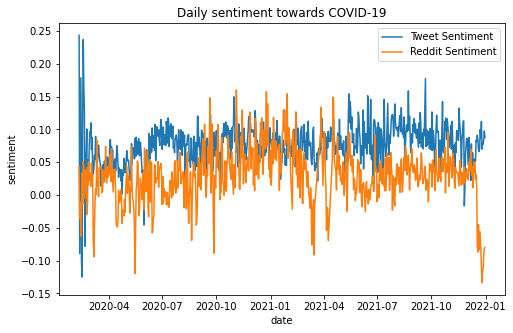

In [ ]:
plt.figure(figsize=(8,5))
sns.lineplot(x='date', y='sentiment', data=tweet_data_day, label='Tweet Sentiment')
sns.lineplot(x='date', y='sentiment', data=reddit_data_day, label='Reddit Sentiment')
plt.title('Daily sentiment towards COVID-19')